In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from collections import defaultdict
import sys
import plot_utils

In [3]:
"""Simple blackjack environment

Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.
Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).
The game starts with each (player and dealer) having one face up and one
face down card.

The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.

If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21.  The reward for winning is +1,
drawing is 0, and losing is -1.

The observation of a 3-tuple of: the players current sum,
the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1).

This environment corresponds to the version of the blackjack problem
described in Example 5.1 in Reinforcement Learning: An Introduction
by Sutton and Barto (1998).
http://incompleteideas.net/sutton/book/the-book.html
"""

"Simple blackjack environment\n\nBlackjack is a card game where the goal is to obtain cards that sum to as\nnear as possible to 21 without going over.  They're playing against a fixed\ndealer.\nFace cards (Jack, Queen, King) have point value 10.\nAces can either count as 11 or 1, and it's called 'usable' at 11.\nThis game is placed with an infinite deck (or with replacement).\nThe game starts with each (player and dealer) having one face up and one\nface down card.\n\nThe player can request additional cards (hit=1) until they decide to stop\n(stick=0) or exceed 21 (bust).\n\nAfter the player sticks, the dealer reveals their facedown card, and draws\nuntil their sum is 17 or greater.  If the dealer goes bust the player wins.\n\nIf neither player nor dealer busts, the outcome (win, lose, draw) is\ndecided by whose sum is closer to 21.  The reward for winning is +1,\ndrawing is 0, and losing is -1.\n\nThe observation of a 3-tuple of: the players current sum,\nthe dealer's one showing card

In [4]:
# Actions: Hit(Request additional cards), Stick(Stop)
# Rewards: Win(+1), Draw(0), Lose(-1)
# State: Players current sum, dealer's one showing card, player holds a usable ace

In [5]:
class blackjack_game:
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.actions = [0, 1] # stick, hit
        
    def draw(self, cards):
        new = self.deck[np.random.choice(np.arange(13))]
        
        cards.append(new)
        cards, is_usable = self.check_usable(cards)
        
        return cards, is_usable        
    
    def get_action(self, action=None, probs=[0.5, 0.5]):
        if action == None:
            action = self.actions[np.random.choice(np.arange(2), p=probs)]
                       
        return action
    
    def check_usable(self, cards):
        if sum(cards) + 10 <= 21:
            cards = [11 if c == 1 else c for c in cards]
        else:
            cards = [1 if c == 11 else c for c in cards]
            
        return cards, 11 in cards
    
    def get_state(self):
        return (sum(self.player_cards), sum(self.dealer_cards), self.is_usable)
    
    def get_result(self, action):
        if action == 0:        
            while sum(self.dealer_cards) < 17:
                self.dealer_cards, _ = self.draw(self.dealer_cards)
            
        if sum(self.player_cards) > 21: # player bust
            return -1
        elif sum(self.dealer_cards) > 21: # dealer bust
            return 1
        elif action == 1:
            return 0
        else:
            return 1 if 21 - sum(self.player_cards) < 21 - sum(self.dealer_cards) else -1

    def init_game(self):
        self.player_cards, _ = self.draw([])
        self.player_cards, self.is_usable = self.draw(self.player_cards)
        self.dealer_cards, _ = self.draw([])
        self.state = self.get_state()
        
        return self.state
    
    def step(self, action):
        if action == 1: # hit
            self.player_cards, self.is_usable = self.draw(self.player_cards)
            
        reward = self.get_result(action)
        done = reward != 0
        state = self.get_state()
        
        return state, reward, done

In [6]:
env = blackjack_game()

In [7]:
for i_episode in range(3):
    state = env.init_game()
    while True:
        print(state)
        action = env.get_action()
        state, reward, done = env.step(action)
        if done:
            print('End game! Reards: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(13, 7, False)
End game! Reards:  -1
You lost :(

(17, 7, False)
End game! Reards:  -1
You lost :(

(18, 3, False)
End game! Reards:  1
You won :)



In [8]:
def generate_episode(env, verbose=True):
    episode = []
    state = env.init_game()
    while True:
        if verbose: print(state)
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = env.get_action(probs=probs)
        next_state, reward, done = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            if verbose: print('End game! Reards: ', reward)
            if verbose: print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break
    return episode

In [9]:
generate_episode(env)

(6, 10, False)
(15, 10, False)
End game! Reards:  -1
You lost :(



[((6, 10, False), 1, 0), ((15, 10, False), 1, -1)]

In [11]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(len(env.actions)))
    N = defaultdict(lambda: np.zeros(len(env.actions)))
    Q = defaultdict(lambda: np.zeros(len(env.actions)))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode(env, False)
        states, actions, rewards = zip(*episode)
        discount_rates = [gamma**i for i in range(len(rewards))]
        
        for i, state in enumerate(states):
            G = sum([rewards[j] * discount_rates[j] for j in range(len(rewards[i:]))])
            returns_sum[state][actions[i]] += G
            N[state][actions[i]] += 1
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
            
    return Q

In [ ]:
Q = mc_prediction_q(env, 500000, generate_episode)
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) for k, v in Q.items())

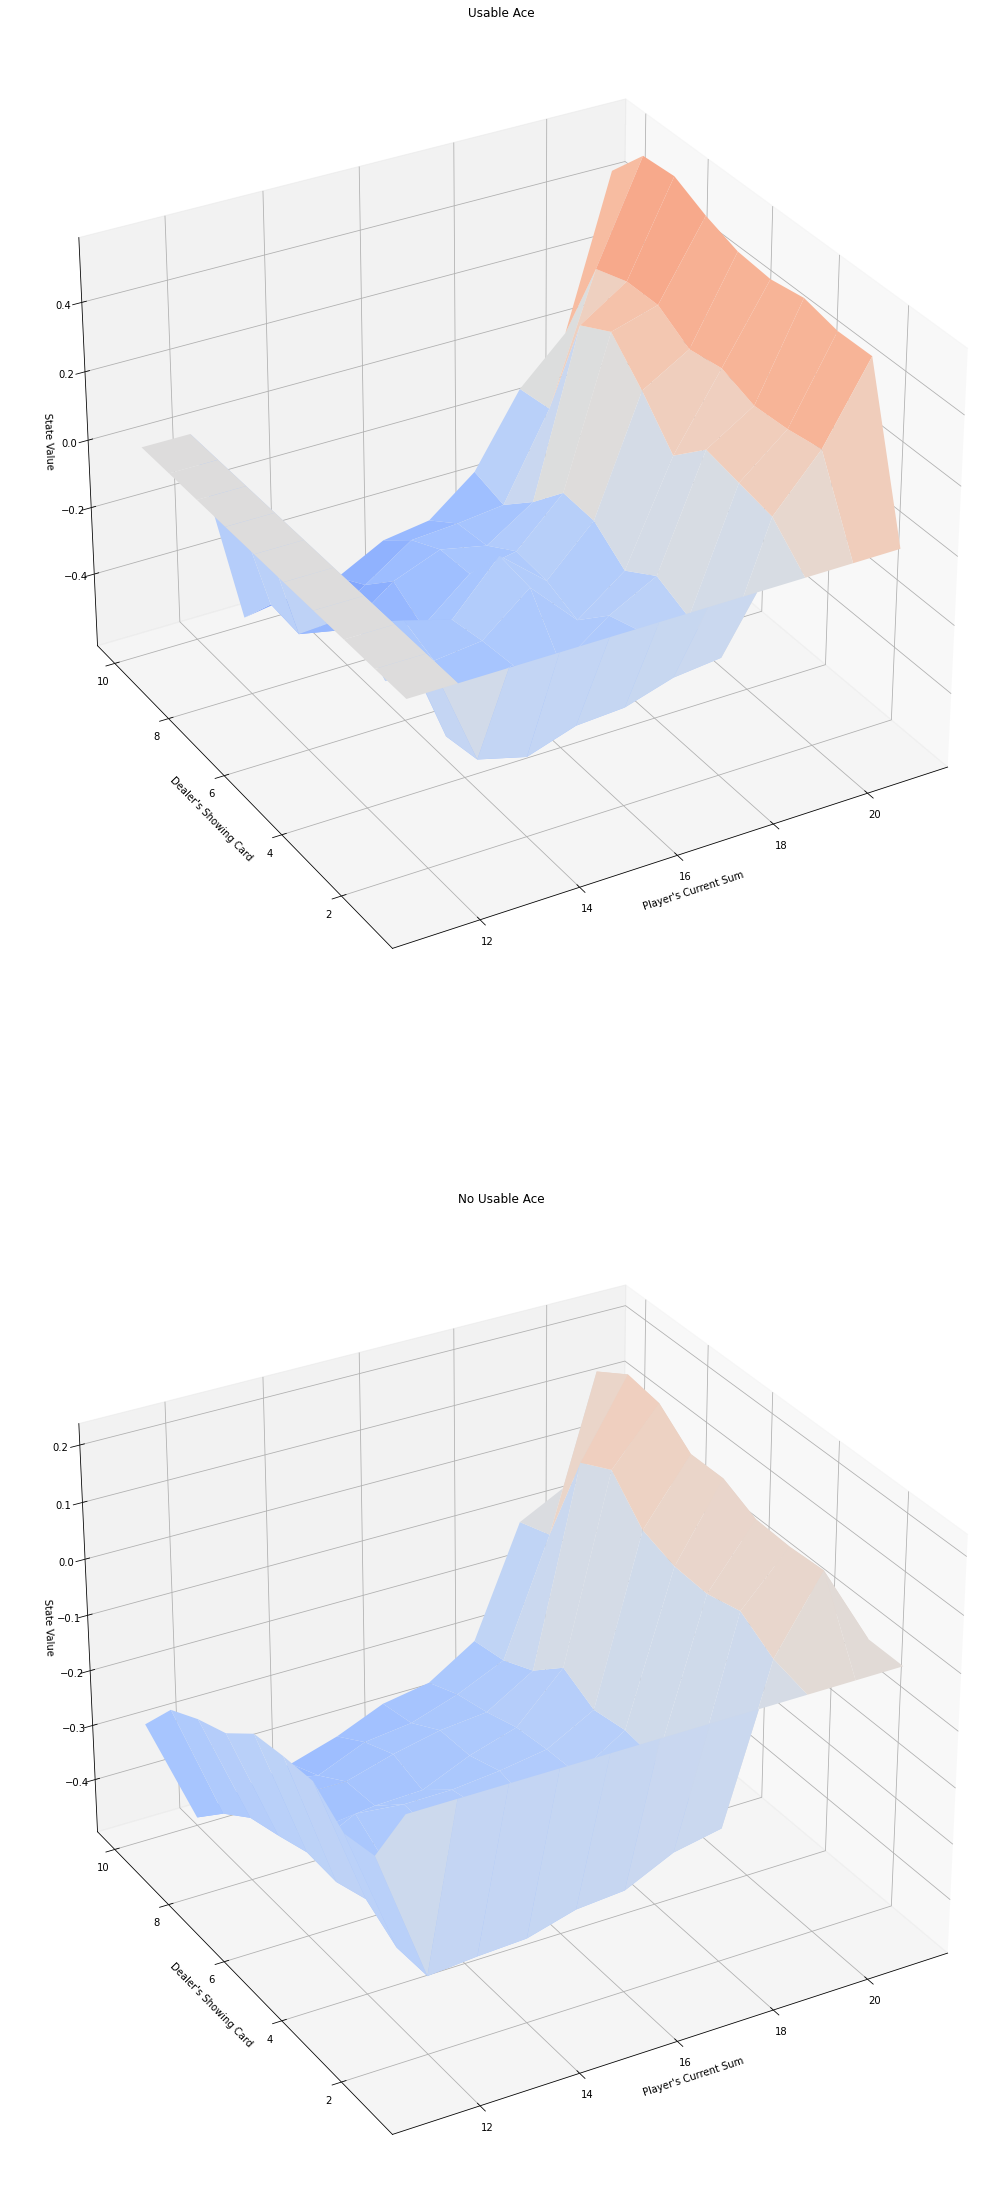

In [25]:
plot_utils.plot_blackjack_values(V_to_plot)